In [1]:
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

C:\Users\User\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
from scipy import interp
from sklearn.metrics import roc_auc_score

In [3]:
dataset = pd.read_csv(r'AM_IM_SS_Multi.csv')
dataset.head()

,Alloy,No,Component,Fraction,a,delta,Tm,D_Tm,Hmix,?Hmix,Sid,Elec_nega,D_elec_nega,VEC,d_VEC,BulkModulus,D_Bulk,Phase_inshort
0,Zr45.38Ti9.62Cu8.75Ni10Be26.25,5,Zr Ti Cu Ni Be,45.38 9.62 8.75 10 26.25,1.400611,0.146608,1853.515475,283.938040,-37.996770,12.967122,1.378296,1.521077,0.211945,4.687500,2.909440,1.070000e+11,36.898355,AM
1,AlCoCu,3,Al Co Cu,7 1 2,1.383100,0.054241,1101.783000,278.066294,-5.400000,4.272798,0.801819,1.695000,0.129942,5.200000,3.400000,9.920000e+10,36.912870,IM
2,Al20Li20Mg10Sc20Ti30,5,Al Li Mg Sc Ti,20 20 10 20 30,1.517100,0.051625,1314.832000,600.177793,-0.400000,14.116742,1.557113,1.383000,0.225435,2.800000,1.077033,6.630000e+10,35.581034,SS
3,CoCrCuFeZr0.8,5,Co Cr Cu Fe Zr,1 1 1 1 0.8,1.312792,0.099336,1837.327083,295.977082,-9.687500,10.484101,1.605807,1.736250,0.201097,7.750000,2.349645,1.470000e+11,36.733420,AM+IM
4,Al0.5CoCrCuFeNiTi1.4,7,Al Co Cr Cu Fe Ni Ti,0.5 1 1 1 1 1 1.4,1.308377,0.069377,1743.319565,324.684788,-14.022264,9.492334,1.913480,1.759565,0.147643,7.405797,2.704365,1.480000e+11,32.645454,IM+SS


In [4]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [5]:
X = dataset.iloc[:,4:17].values
y = dataset.iloc[:,17].values

In [6]:
y_bin = label_binarize(y, classes=['AM', 'AM+IM', 'IM', 'IM+SS', 'SS'])
n_classes = y_bin.shape[1]

y_bin

array([[1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0]])

In [7]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [8]:
model = OneVsRestClassifier(RandomForestClassifier(n_estimators =25, max_features=5, max_depth = 128, criterion = 'entropy', random_state = 42))

In [9]:
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))


Accuracy: 0.880 (0.047)


In [10]:
y_pred = cross_val_predict(model, X, y, cv=cv)
y_score = cross_val_predict(model, X, y, cv=cv, method='predict_proba') 

In [11]:
confusion_matrix(y, y_pred)

array([[150,   0,  11,   1,   3],
       [  1,   1,   1,   3,   0],
       [  7,   0, 234,   3,   4],
       [  1,   1,   0,  29,  20],
       [  1,   1,   4,  10, 115]], dtype=int64)

In [12]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
lw = 2

y_bin

array([[1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0]])

In [13]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [14]:
# For each class

precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_bin[:, i], y_score[:, i])
    

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_bin.ravel(), y_score.ravel())
average_precision["micro"] = average_precision_score(y_bin, y_score, average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.93


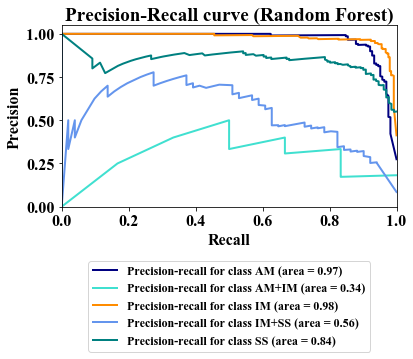

In [15]:
from itertools import cycle
from matplotlib.pyplot import figure
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = '16'

colors=cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
lines=[]
labels=[]
phases = ['AM', 'AM+IM', 'IM', 'IM+SS', 'SS']

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                 ''.format(phases[i], average_precision[i]))
    
fig=plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve (Random Forest)')
plt.legend(lines, labels, loc=(0.08, -.8), prop=dict(size=12))